# 2.7 - Vanishing gradients

Course's materials require a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

In [ ]:
import os
def downgrade_tf_version():
    os.system("!yes | pip uninstall -y tensorflow")
    os.system("!yes | pip install tensorflow==2.12.0")
    os.kill(os.getpid(), 9)
downgrade_tf_version()

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
%matplotlib inline
import tensorflow as tf
tf.__version__

'2.1.0'

forward/back propagation calculations [https://medium.com/@14prakash/back-propagation-is-very-simple-who-made-it-complicated-97b794c97e5c](https://medium.com/@14prakash/back-propagation-is-very-simple-who-made-it-complicated-97b794c97e5c)

Vanishing gradient example: [https://github.com/harinisuresh/VanishingGradient/blob/master/Vanishing%20Gradient%20Example.ipynb](https://github.com/harinisuresh/VanishingGradient/blob/master/Vanishing%20Gradient%20Example.ipynb)

[https://adventuresinmachinelearning.com/vanishing-gradient-problem-tensorflow/](https://adventuresinmachinelearning.com/vanishing-gradient-problem-tensorflow/)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

%matplotlib inline

## Visualizing and understanding vanishing gradients

Make sure you understand well the backpropagation algorithm. You may perform by hand the calculations as illustrated [here](https://medium.com/@14prakash/back-propagation-is-very-simple-who-made-it-complicated-97b794c97e5c) to consolidate your understanding.

We will be using three activation functions. Observe under which what values each function's gradient becomes negligible (very near zero)



### sigmoid

$$\text{sigm(z)} = \frac{1}{1-e^{-z}}$$

$$\frac{\partial \;\text{sigm}}{\partial \; z} = \text{sigm}(z)(1-\text{sigm}(z))$$


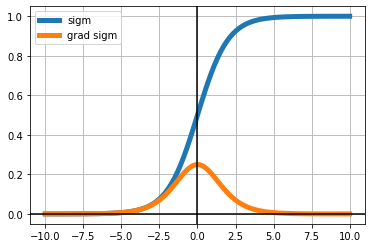

In [5]:
z = np.linspace(-10,10,100)

sigm = lambda z: 1/(1+np.exp(-z))

dsigm = lambda z: sigm(z)*(1-sigm(z))

plt.plot(z, sigm(z), lw=5, label="sigm")
plt.plot(z, dsigm(z), lw=5, label="grad sigm")
plt.grid()
plt.axvline(0, color="black");
plt.axhline(0, color="black");
plt.legend()

### tanh

$$\text{tanh(z)} = \frac{e^z - e^{-z}}{e^z-e^{-z}}$$

$$\frac{\partial \;\text{tanh}}{\partial \; z} = 1-\text{tanh}(z)^2$$


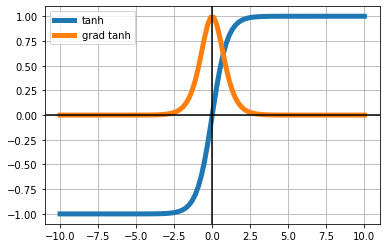

In [6]:
z = np.linspace(-10,10,100)

tanh = lambda z: (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

dtanh = lambda z: 1 - tanh(z)**2

plt.plot(z, tanh(z), lw=5, label="tanh")
plt.plot(z, dtanh(z), lw=5, label="grad tanh")
plt.grid()
plt.axvline(0, color="black");
plt.axhline(0, color="black");
plt.legend()

### ReLU (Rectified Linear Unit)

$$\text{relu}(z) = \text{z if }z<0\;;\;0\text{ otherwise}$$

$$\frac{\partial \;\text{relu}}{\partial \; z} = \text{1 if }z<0\;;\;0\text{ otherwise}$$


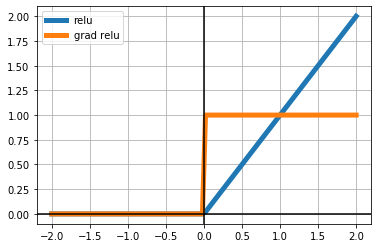

In [7]:
z = np.linspace(-2,2,100)

relu = np.vectorize(lambda z: z if z>0 else 0.)

drelu = np.vectorize(lambda z: 1 if z>0 else 0.)

plt.plot(z, relu(z), lw=5, label="relu")
plt.plot(z, drelu(z), lw=5, label="grad relu")
plt.grid()
plt.axvline(0, color="black");
plt.axhline(0, color="black");
plt.legend()

### Leaky ReLU (Rectified Linear Unit)

$$\text{relu}(z) = \text{z if }z<0\;;\;kz\text{ otherwise with }k<<1$$

$$\frac{\partial \;\text{relu}}{\partial \; z} = \text{1 if }z<0\;;\;k\text{ otherwise}$$


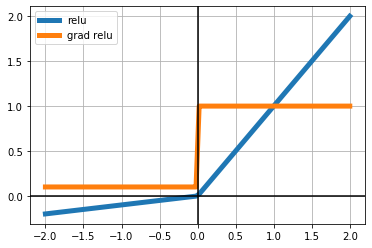

In [8]:
z = np.linspace(-2,2,100)

relu = np.vectorize(lambda z: z if z>0 else .1*z)

drelu = np.vectorize(lambda z: 1 if z>0 else .1)

plt.plot(z, relu(z), lw=5, label="relu")
plt.plot(z, drelu(z), lw=5, label="grad relu")
plt.grid(); 
plt.axvline(0, color="black");
plt.axhline(0, color="black");
plt.legend()

### load sample MNIST data as customary

In [9]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train
X_test  = X_test
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print(X_train.shape, y_train_oh.shape)

(1200, 784) (1200, 10)


In [11]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session
from tensorflow import keras

### A basic multi layered dense model

observe that the function allows us to parametrize the number of hidden layers and their activation function


In [19]:
!rm -rf log 

def get_model(input_dim=784, output_dim=10, num_hidden_layers=6, hidden_size=10, activation="relu"):

    model = Sequential()
    model.add(Dense(hidden_size, activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0)))
    
    for i in range(num_hidden_layers):
        model.add(Dense(hidden_size, activation=activation, name="Layer_%02d_Hidden"%(i+1)))
   
    model.add(Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(num_hidden_layers+1)))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

### SIGMOID activation

In [20]:
model = get_model(num_hidden_layers=10, activation="sigmoid")
!rm -rf log/sigmoid
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/sigmoid', histogram_freq=1,  write_graph=True, write_images=True)
model.fit(X_train, y_train_oh, epochs=30, batch_size=32, validation_data=(X_test, y_test_oh), callbacks=[tb_callback])

Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 1s 528us/sample - loss: 2.3860 - accuracy: 0.0933 - val_loss: 2.3674 - val_accuracy: 0.0967
Epoch 2/30
1200/1200 [==============================] - 0s 124us/sample - loss: 2.3391 - accuracy: 0.0933 - val_loss: 2.3356 - val_accuracy: 0.0967
Epoch 3/30
1200/1200 [==============================] - 0s 129us/sample - loss: 2.3174 - accuracy: 0.1050 - val_loss: 2.3181 - val_accuracy: 0.0733
Epoch 4/30
1200/1200 [==============================] - 0s 102us/sample - loss: 2.3073 - accuracy: 0.1083 - val_loss: 2.3097 - val_accuracy: 0.0733
Epoch 5/30
1200/1200 [==============================] - 0s 106us/sample - loss: 2.3023 - accuracy: 0.1025 - val_loss: 2.3059 - val_accuracy: 0.1367
Epoch 6/30
1200/1200 [==============================] - 0s 97us/sample - loss: 2.3006 - accuracy: 0.1208 - val_loss: 2.3029 - val_accuracy: 0.1367
Epoch 7/30
1200/1200 [==============================] - 0s 95us/sa

### RELU activation

In [14]:
model = get_model(num_hidden_layers=10, activation="relu")
!rm -rf log/relu
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/relu', histogram_freq=1,  write_graph=True, write_images=True)
model.fit(X_train, y_train_oh, epochs=30, batch_size=32, validation_data=(X_test, y_test_oh), callbacks=[tb_callback])

Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 1s 595us/sample - loss: 2.2625 - accuracy: 0.1167 - val_loss: 2.1966 - val_accuracy: 0.1167
Epoch 2/30
1200/1200 [==============================] - 0s 109us/sample - loss: 2.0998 - accuracy: 0.1950 - val_loss: 2.0889 - val_accuracy: 0.2233
Epoch 3/30
1200/1200 [==============================] - 0s 99us/sample - loss: 2.0089 - accuracy: 0.1867 - val_loss: 2.0127 - val_accuracy: 0.1667
Epoch 4/30
1200/1200 [==============================] - 0s 104us/sample - loss: 1.9355 - accuracy: 0.1883 - val_loss: 1.9451 - val_accuracy: 0.1600
Epoch 5/30
1200/1200 [==============================] - 0s 113us/sample - loss: 1.8051 - accuracy: 0.2050 - val_loss: 1.8259 - val_accuracy: 0.1833
Epoch 6/30
1200/1200 [==============================] - 0s 99us/sample - loss: 1.6390 - accuracy: 0.3275 - val_loss: 1.7357 - val_accuracy: 0.2933
Epoch 7/30
1200/1200 [==============================] - 0s 105us/sa

### Leaky RELU activation

In [15]:
import tensorflow as tf
model = get_model(num_hidden_layers=10, activation=tf.nn.leaky_relu)
!rm -rf log/leaky_relu
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/leaky_relu', histogram_freq=1, write_graph=True, write_images=True)
model.fit(X_train, y_train_oh, epochs=30, batch_size=32, validation_data=(X_test, y_test_oh), callbacks=[tb_callback])

Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 1s 562us/sample - loss: 2.2907 - accuracy: 0.1617 - val_loss: 2.2538 - val_accuracy: 0.1700
Epoch 2/30
1200/1200 [==============================] - 0s 120us/sample - loss: 2.1105 - accuracy: 0.1933 - val_loss: 2.0408 - val_accuracy: 0.1867
Epoch 3/30
1200/1200 [==============================] - 0s 112us/sample - loss: 1.9159 - accuracy: 0.2242 - val_loss: 1.8557 - val_accuracy: 0.2367
Epoch 4/30
1200/1200 [==============================] - 0s 93us/sample - loss: 1.7480 - accuracy: 0.2817 - val_loss: 1.7438 - val_accuracy: 0.2800
Epoch 5/30
1200/1200 [==============================] - 0s 86us/sample - loss: 1.5951 - accuracy: 0.3467 - val_loss: 1.6657 - val_accuracy: 0.3400
Epoch 6/30
1200/1200 [==============================] - 0s 91us/sample - loss: 1.4818 - accuracy: 0.3917 - val_loss: 1.5912 - val_accuracy: 0.3567
Epoch 7/30
1200/1200 [==============================] - 0s 97us/samp

### SIGMOID activation but longer run (epochs)

In [16]:
model = get_model(num_hidden_layers=10, activation="sigmoid")
!rm -rf log/sigmoid_longrun
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/sigmoid_longrun', histogram_freq=1, write_graph=True, write_images=True)
model.fit(X_train, y_train_oh, epochs=300, batch_size=32, validation_data=(X_test, y_test_oh), callbacks=[tb_callback])

Train on 1200 samples, validate on 300 samples
Epoch 1/300
1200/1200 [==============================] - 1s 651us/sample - loss: 2.4060 - accuracy: 0.1083 - val_loss: 2.4034 - val_accuracy: 0.0733
Epoch 2/300
1200/1200 [==============================] - 0s 146us/sample - loss: 2.3483 - accuracy: 0.1083 - val_loss: 2.3558 - val_accuracy: 0.0733
Epoch 3/300
1200/1200 [==============================] - 0s 95us/sample - loss: 2.3228 - accuracy: 0.1083 - val_loss: 2.3319 - val_accuracy: 0.0733
Epoch 4/300
1200/1200 [==============================] - 0s 94us/sample - loss: 2.3105 - accuracy: 0.1083 - val_loss: 2.3200 - val_accuracy: 0.0733
Epoch 5/300
1200/1200 [==============================] - 0s 93us/sample - loss: 2.3049 - accuracy: 0.1083 - val_loss: 2.3140 - val_accuracy: 0.0733
Epoch 6/300
1200/1200 [==============================] - 0s 98us/sample - loss: 2.3020 - accuracy: 0.1083 - val_loss: 2.3091 - val_accuracy: 0.0733
Epoch 7/300
1200/1200 [==============================] - 0s 103

Epoch 56/300
1200/1200 [==============================] - 0s 95us/sample - loss: 2.2988 - accuracy: 0.1208 - val_loss: 2.3012 - val_accuracy: 0.1367
Epoch 57/300
1200/1200 [==============================] - 0s 98us/sample - loss: 2.2991 - accuracy: 0.1208 - val_loss: 2.3012 - val_accuracy: 0.1367
Epoch 58/300
1200/1200 [==============================] - 0s 79us/sample - loss: 2.2993 - accuracy: 0.1208 - val_loss: 2.3025 - val_accuracy: 0.1367
Epoch 59/300
1200/1200 [==============================] - 0s 75us/sample - loss: 2.2987 - accuracy: 0.1208 - val_loss: 2.3010 - val_accuracy: 0.1367
Epoch 60/300
1200/1200 [==============================] - 0s 73us/sample - loss: 2.2992 - accuracy: 0.1208 - val_loss: 2.3007 - val_accuracy: 0.1367
Epoch 61/300
1200/1200 [==============================] - 0s 70us/sample - loss: 2.2989 - accuracy: 0.1208 - val_loss: 2.3018 - val_accuracy: 0.1367
Epoch 62/300
1200/1200 [==============================] - 0s 78us/sample - loss: 2.2987 - accuracy: 0.1208

Epoch 111/300
1200/1200 [==============================] - 0s 116us/sample - loss: 1.8808 - accuracy: 0.2125 - val_loss: 1.9769 - val_accuracy: 0.1833
Epoch 112/300
1200/1200 [==============================] - 0s 86us/sample - loss: 1.8805 - accuracy: 0.2150 - val_loss: 1.9790 - val_accuracy: 0.1867
Epoch 113/300
1200/1200 [==============================] - 0s 103us/sample - loss: 1.8834 - accuracy: 0.2175 - val_loss: 1.9581 - val_accuracy: 0.1900
Epoch 114/300
1200/1200 [==============================] - 0s 88us/sample - loss: 1.8809 - accuracy: 0.2175 - val_loss: 1.9681 - val_accuracy: 0.1867
Epoch 115/300
1200/1200 [==============================] - 0s 84us/sample - loss: 1.8578 - accuracy: 0.2200 - val_loss: 1.9434 - val_accuracy: 0.1967
Epoch 116/300
1200/1200 [==============================] - 0s 79us/sample - loss: 1.8657 - accuracy: 0.2192 - val_loss: 1.9675 - val_accuracy: 0.1867
Epoch 117/300
1200/1200 [==============================] - 0s 83us/sample - loss: 1.8694 - accurac

Epoch 220/300
1200/1200 [==============================] - 0s 77us/sample - loss: 1.8191 - accuracy: 0.2150 - val_loss: 1.9720 - val_accuracy: 0.2067
Epoch 221/300
1200/1200 [==============================] - 0s 85us/sample - loss: 1.8210 - accuracy: 0.2175 - val_loss: 1.9725 - val_accuracy: 0.1867
Epoch 222/300
1200/1200 [==============================] - 0s 71us/sample - loss: 1.8351 - accuracy: 0.2200 - val_loss: 2.0701 - val_accuracy: 0.2067
Epoch 223/300
1200/1200 [==============================] - 0s 80us/sample - loss: 1.9326 - accuracy: 0.2208 - val_loss: 2.0633 - val_accuracy: 0.2033
Epoch 224/300
1200/1200 [==============================] - 0s 70us/sample - loss: 1.8287 - accuracy: 0.2217 - val_loss: 1.9644 - val_accuracy: 0.1867
Epoch 225/300
1200/1200 [==============================] - 0s 80us/sample - loss: 1.8126 - accuracy: 0.2225 - val_loss: 1.9478 - val_accuracy: 0.1933
Epoch 226/300
1200/1200 [==============================] - 0s 84us/sample - loss: 1.7974 - accuracy:

## Experiment observations, on Tensorboard

- What is the distribution of the weights observed as we move from the output layer to the input layer for each experiment? 

- Look in [Tensorboard](http://localhost:6006) at distributions or histograms charts named `Layer_00_Input/kernel_0`, `Layer_01_Hidden/kernel_0`, etc. for different layers. You should see:
    - Gradients are usually higher at the output layer and tend to decrease as you move backwards in the network.
    - With sigmoid activations gradients are always low and rapidly decay from the output layer all the way to the input layer.
    - Relu might still have some vanishing gradient when weights are <0.
    - Leaky Relu would probably have constant gradients across layers.
    

- Recall that, in the backpropagation algorithm, the gradient of the loss function $L$ with respect to the weights at a certain layer $W_l$ is proportional to the derivatives and the weights of previous layers:

$$\frac{\partial L}{\partial W_l} \propto f'(z^{(l)})\cdot W_l \cdot f'(z^{(l+1)})\cdot W_{l+1} \cdot f'(z^{(l+2)})\cdot W_{l+2}...$$

where $f'$ is the derivative of the activation function and $z^{(l)}$ is the output at layer $l$.

- Do you think the sigmoid longrun would reach levels comparable to Relu or Leaky Relu? At what computational cost?


In [17]:
%load_ext tensorboard
%tensorboard --logdir log